In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data


In [9]:
import os 
os.chdir("/content/drive/My Drive/Image_super_resolution/github_implementation")
os.getcwd()
!ls

crop_train.h5  pre2.jpg		__pycache__	    test.h5
flower.jpg     prepare_data.py	SRCNN_check.h5	    test_rgb.h5
input2.jpg     pre_rgb.jpg	SRCNN_check_rgb.h5  train_rgb.h5


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint,Callback
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import prepare_data as pd
import numpy 
import math

(4083, 32, 32, 1) (4083, 20, 20, 1)
83.0
(420, 32, 32, 1) (420, 20, 20, 1)


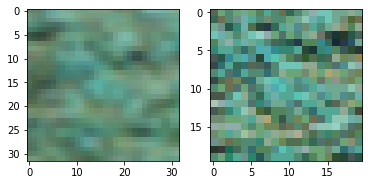

In [139]:

%matplotlib inline
data_rgb,label_rgb=pd.read_training_data("test_rgb.h5")
print(data.shape,label.shape)
print(data[0][0][0][0])
data_img=data_rgb[5]
label_img=label_rgb[5]
data=data*255
label=label*255
fig,axes=plt.subplots(1,2)
axes[0].imshow(data_img)
axes[1].imshow(label_img)
data_Y, label_Y = pd.read_training_data("./test.h5")
print(data_Y.shape,label_Y.shape)

In [0]:
def psnr(target, ref):
    mse = numpy.mean( (target - ref) ** 2 )
    PIXEL_MAX = 255.0
    if mse == 0:
        return 100
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [0]:
def model():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    SRCNN.add(Conv2D(nb_filter=128, nb_row=9, nb_col=9, init='glorot_uniform',
                     activation='relu', border_mode='valid', bias=True, input_shape=(32, 32, 1)))
    SRCNN.add(Conv2D(nb_filter=64, nb_row=3, nb_col=3, init='glorot_uniform',
                     activation='relu', border_mode='same', bias=True))
    # SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(nb_filter=1, nb_row=5, nb_col=5, init='glorot_uniform',
                     activation='linear', border_mode='valid', bias=True))
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN


def predict_model():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    SRCNN.add(Conv2D(nb_filter=128, nb_row=9, nb_col=9, init='glorot_uniform',
                     activation='relu', border_mode='valid', bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(nb_filter=64, nb_row=3, nb_col=3, init='glorot_uniform',
                     activation='relu', border_mode='same', bias=True))
    # SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(nb_filter=1, nb_row=5, nb_col=5, init='glorot_uniform',
                     activation='linear', border_mode='valid', bias=True))
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN

class PsnrHistory_Y(Callback):
    def on_train_begin(self, logs={}):
        self.psnrs = []
        
    def on_epoch_end(self, epoch, logs={}):
        srcnn_model = predict_model()
        srcnn_model.load_weights("SRCNN_check.h5")
        avg_psnr=0.0
        import cv2
        for i in range(0,data_Y.shape[0]):
            img=data_Y[i]
            Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
            Y[0, :, :, :] = img
            pre = srcnn_model.predict(Y, batch_size=1) * 255.
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0] = 0
            img_pre=pre[0,:,:,:]
            avg_psnr=avg_psnr+psnr(label_Y[i]*255, img_pre)

        avg_psnr=(avg_psnr/data_rgb.shape[0])
        # avg_psnr2=0.0
        # for i in range(0,data_rgb.shape[0]):
        #     img = cv2.cvtColor(data_rgb[i], cv2.COLOR_BGR2YCrCb)
        #     Y_img=data_Y[i]
        #     Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
        #     Y[0, :, :, :] = Y_img
        #     pre = srcnn_model.predict(Y, batch_size=1) * 255.
        #     pre[pre[:] > 255] = 255
        #     pre[pre[:] < 0] = 0
        #     img=img[6: -6, 6: -6,:]
        #     img[:,:,0]=pre[0,:,:,0]
        #     img=cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
        #     avg_psnr2=avg_psnr2+psnr(label_rgb[i]*255, img)
        
        # avg_psnr2=(avg_psnr2/data_rgb.shape[0])
        
        self.psnrs.append((avg_psnr))


def train(history):
    srcnn_model = model()
    print(srcnn_model.summary())
    data, label = pd.read_training_data("./crop_train.h5")
    val_data, val_label = pd.read_training_data("./test.h5")

    checkpoint = ModelCheckpoint("SRCNN_check.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint,history]

    srcnn_model.fit(data, label, batch_size=128, validation_data=(val_data, val_label),
                    callbacks=callbacks_list, shuffle=True, nb_epoch=20, verbose=0)
    # srcnn_model.load_weights("m_model_adam.h5")

In [0]:
def predict():
    srcnn_model = predict_model()
    srcnn_model.load_weights("SRCNN_check.h5")
    IMG_NAME = "flower.png"
    INPUT_NAME = "input2.png"
    OUTPUT_NAME = "pre2.png"

    import cv2
    img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    shape = img.shape
    Y_img = cv2.resize(img[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)
    Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    print(img.shape,Y_img.shape)
    img[:, :, 0] = Y_img
    Y_img=img[:,:,0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(INPUT_NAME, img)

    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = Y_img.astype(float) / 255.
    pre = srcnn_model.predict(Y, batch_size=1) * 255.
    print(pre.shape)
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(numpy.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    print(img.shape)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1_rgb = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)[6: -6, 6: -6, :]
    im1_Y = cv2.cvtColor(im1_rgb, cv2.COLOR_BGR2YCrCb)
    im2_rgb = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)[6: -6, 6: -6, :]
    im2_Y = cv2.cvtColor(im2_rgb, cv2.COLOR_BGR2YCrCb)
    im3_rgb = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)[6: -6, 6: -6, :]
    im3_Y = cv2.cvtColor(im3_rgb, cv2.COLOR_BGR2YCrCb)
    print(im3_Y.shape,im1_Y.shape)
    print("bicubic:")
    print("YCrCCb= {} , RGB={}".format(psnr(im1_Y[:,:,0],im2_Y[:,:,0]),psnr(im1_rgb,im2_rgb)))
    print("SRCNN:")
    print("YCrCCb= {} , RGB={}".format(psnr(im1_Y[:,:,0],im3_Y[:,:,0]),psnr(im1_rgb,im3_rgb)))

    # srcnn_model = predict_model()
    # srcnn_model.load_weights("SRCNN_check.h5")
    # avg_psnr=0.0
    # for i in range(0,data_Y.shape[0]):
    #     img=data_Y[i]
    #     Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    #     Y[0, :, :, :] = img
    #     pre = srcnn_model.predict(Y, batch_size=1) * 255.
    #     pre[pre[:] > 255] = 255
    #     pre[pre[:] < 0] = 0
    #     img_pre=pre[0,:,:,:]
    #     avg_psnr=avg_psnr+psnr(label_Y[i]*255, img_pre)

    # avg_psnr=(avg_psnr/data_rgb.shape[0])
    # print(avg_psnr)

In [189]:
history_Y=PsnrHistory_Y()
train(history_Y)
print(history_Y.psnrs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", input_shape=(32, 32, 1..., kernel_size=(9, 9), filters=128, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", kernel_size=(3, 3), filters=64, padding="same", kernel_initializer="glorot_uniform", use_bias=True)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="linear", kernel_size=(5, 5), filters=1, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_460 (Conv2D)          (None, 24, 24, 128)       10496     
_________________________________________________________________
conv2d_461 (Conv2D)          (None, 24, 24, 64)        73792     
_________________________________________________________________
conv2d_462 (Conv2D)          (None, 20, 20, 1)         1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.00738, saving model to SRCNN_check.h5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", input_shape=(None, Non..., kernel_size=(9, 9), filters=128, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", kernel_size=(3, 3), filters=64, padding="same", kernel_initializer="glorot_uniform", use_bias=True)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="linear", kernel_size=(5, 5), filters=1, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`



Epoch 00002: val_loss improved from 0.00738 to 0.00417, saving model to SRCNN_check.h5

Epoch 00003: val_loss improved from 0.00417 to 0.00315, saving model to SRCNN_check.h5

Epoch 00004: val_loss improved from 0.00315 to 0.00265, saving model to SRCNN_check.h5

Epoch 00005: val_loss improved from 0.00265 to 0.00237, saving model to SRCNN_check.h5

Epoch 00006: val_loss improved from 0.00237 to 0.00222, saving model to SRCNN_check.h5

Epoch 00007: val_loss improved from 0.00222 to 0.00210, saving model to SRCNN_check.h5

Epoch 00008: val_loss improved from 0.00210 to 0.00202, saving model to SRCNN_check.h5

Epoch 00009: val_loss improved from 0.00202 to 0.00201, saving model to SRCNN_check.h5

Epoch 00010: val_loss improved from 0.00201 to 0.00195, saving model to SRCNN_check.h5

Epoch 00011: val_loss did not improve from 0.00195

Epoch 00012: val_loss improved from 0.00195 to 0.00191, saving model to SRCNN_check.h5

Epoch 00013: val_loss improved from 0.00191 to 0.00189, saving mode

[24.4731934827105, 27.793454270239536, 29.14313286634138, 29.941588982348396, 30.80665296695036, 30.736880884246148, 31.188810082331255, 31.43273100423112, 31.030985663040394, 31.577366631291273, 31.577366631291273, 31.893522585551914, 31.875108684411746, 31.898183555490906, 31.9541851304531, 31.9541851304531, 32.033924283781126, 32.0354016707506, 31.855526727225886, 31.873456331941014]
(20,) (20,)


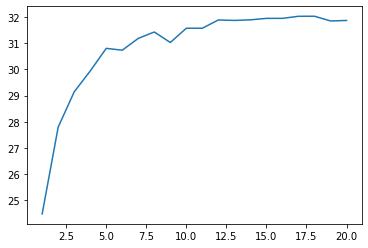

In [190]:
print(history_Y.psnrs)
x=numpy.linspace(1,len(history_Y.psnrs),len(history_Y.psnrs))
y = numpy.asarray(history_Y.psnrs, dtype=numpy.float32)
print(x.shape,y.shape)
plt.plot(x,history_Y.psnrs)

In [213]:
predict()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", input_shape=(None, Non..., kernel_size=(9, 9), filters=128, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", kernel_size=(3, 3), filters=64, padding="same", kernel_initializer="glorot_uniform", use_bias=True)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="linear", kernel_size=(5, 5), filters=1, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`


(276, 276, 3) (276, 276)
(1, 264, 264, 1)
(276, 276, 3)
(264, 264, 3) (264, 264, 3)
bicubic:
YCrCCb= 33.58214074570319 , RGB=33.57164752219919
SRCNN:
YCrCCb= 34.15214136681098 , RGB=34.11180665939298


In [0]:

def predict_model_rgb():
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 3)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=3, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN


def model_rgb():
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(32, 32, 3)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=3, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN

class PsnrHistory(Callback):
    def on_train_begin(self, logs={}):
        self.psnrs = []
        
    def on_epoch_end(self, epoch, logs={}):
        rmse = math.sqrt(logs['val_loss'])
        psnr2=20 * math.log10(1/rmse)
        srcnn_model = predict_model_rgb()
        srcnn_model.load_weights("SRCNN_check_rgb.h5")
        avg_psnr=0.0
        for i in range(0,data_rgb.shape[0]):
            img=data_rgb[i]
            Y = numpy.zeros((1, img.shape[0], img.shape[1], 3), dtype=float)
            Y[0, :, :, :] = img
            pre = srcnn_model.predict(Y, batch_size=1) * 255.
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0] = 0
            img_pre=pre[0,:,:,:]
            avg_psnr=avg_psnr+psnr(label_rgb[i]*255, img_pre)
        
        avg_psnr=(avg_psnr/data_rgb.shape[0])
        self.psnrs.append(avg_psnr)

def train_rgb(history):
    srcnn_model = model_rgb()
    print(srcnn_model.summary())
    data, label = pd.read_training_data("./train_rgb.h5")
    val_data, val_label = pd.read_training_data("./test_rgb.h5")

    checkpoint = ModelCheckpoint("SRCNN_check_rgb.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint,history]

    srcnn_model.fit(data, label, batch_size=128, validation_data=(val_data, val_label),
                    callbacks=callbacks_list, shuffle=True, epochs=20, verbose=0)
    return history
    # srcnn_model.load_weights("m_model_adam.h5")


In [193]:
history=PsnrHistory()
train_rgb(history)
print(history.psnrs)

Model: "sequential_176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_526 (Conv2D)          (None, 24, 24, 128)       31232     
_________________________________________________________________
conv2d_527 (Conv2D)          (None, 24, 24, 64)        73792     
_________________________________________________________________
conv2d_528 (Conv2D)          (None, 20, 20, 3)         4803      
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.00969, saving model to SRCNN_check_rgb.h5

Epoch 00002: val_loss improved from 0.00969 to 0.00536, saving model to SRCNN_check_rgb.h5

Epoch 00003: val_loss improved from 0.00536 to 0.00402, saving model to SRCNN_check_rgb.h5

Epoch 00004: val_loss improved from 0.00402 to 0.00347, saving model to SRCNN_check_rgb.h5

Epoch 

In [0]:
def predict_rgb():
    srcnn_model = predict_model_rgb()
    srcnn_model.load_weights("SRCNN_check_rgb.h5")
    IMG_NAME = "flower.png"
    INPUT_NAME = "input2_rgb.png"
    OUTPUT_NAME = "pre_rgb.png"

    import cv2
    img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    shape = img.shape
    Y_img = cv2.resize(img[:, :, :], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)
    Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    img=Y_img
    print(Y_img.shape)
    cv2.imwrite(INPUT_NAME, Y_img)

    Y = numpy.zeros((1, img.shape[0], img.shape[1], 3), dtype=float)
    Y[0, :, :, :] = Y_img.astype(float) / 255.
    pre = srcnn_model.predict(Y, batch_size=1) * 255.
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(numpy.uint8)
    img[6: -6, 6: -6,:]=pre[0,:,:,:]
    print(img.shape)
    cv2.imwrite(OUTPUT_NAME, img)


    # psnr calculation:
    im1_rgb = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)[6: -6, 6: -6]
    im1_Y = cv2.cvtColor(im1_rgb, cv2.COLOR_BGR2YCrCb)
    im2_rgb = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)[6: -6, 6: -6]
    im2_Y = cv2.cvtColor(im2_rgb, cv2.COLOR_BGR2YCrCb)
    im3_rgb = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)[6: -6, 6: -6]
    im3_Y = cv2.cvtColor(im3_rgb, cv2.COLOR_BGR2YCrCb)

    print(im1_Y.shape,im2_Y.shape)
    print("bicubic:")
    print("YCrCCb= {} , RGB={}".format(psnr(im1_Y[:,:,0],im2_Y[:,:,0]),psnr(im1_rgb,im2_rgb)))
    print("SRCNN:")
    print("YCrCCb= {} , RGB={}".format(psnr(im1_Y[:,:,0],im3_Y[:,:,0]),psnr(im1_rgb,im3_rgb)))

1.0 (20,)


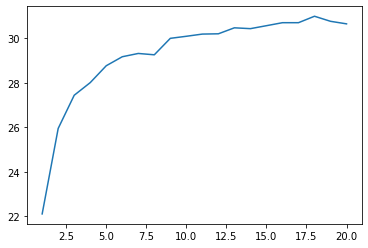

In [194]:
x=numpy.linspace(1,len(history.psnrs),len(history.psnrs))
y = numpy.asarray(history.psnrs, dtype=numpy.float32)
print(x[0],y.shape)
plt.plot(x,history.psnrs)

In [217]:
predict_rgb()



(276, 276, 3)
(276, 276, 3)
(264, 264, 3) (264, 264, 3)
bicubic:
YCrCCb= 33.577765973062625 , RGB=32.56036165104796
SRCNN:
YCrCCb= 33.87933062993204 , RGB=32.57475283303932
